In [12]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
import scipy
from lmfit import Model
from mpl_point_clicker import clicker

In [13]:
%matplotlib widget

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial.transform import Rotation
from sympy import Matrix, pi, pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class TNG50DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.chunk_size = 102609 // 9
        self.load_data()

    def load_data(self):
        chunks = pd.read_csv(self.file_path, sep=',', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=0, chunksize=self.chunk_size)
        self.accumulated_data = np.concatenate([chunk.values for chunk in chunks])

    def calculate_center_of_mass_new(self, value_energy=2.63):
        Log_energy = np.log10(self.accumulated_data[:, 10])
        avg_energy = np.mean(Log_energy)
        if value_energy == 1:
            value_energy = avg_energy
        energy_filter = Log_energy < value_energy
        self.filtered_data = self.accumulated_data[energy_filter]
        return np.sum(self.filtered_data[:, :3], axis=0) / len(self.accumulated_data)

    def calculate_total_angular_momentum(self):
        center_of_mass = self.calculate_center_of_mass_new()
        r_i = self.filtered_data[:, :3] - center_of_mass
        v_i = self.filtered_data[:, 3:6] - self.calculate_velocity_of_mass()
        return np.sum(np.cross(r_i, v_i), axis=0)

    def calculate_velocity_of_mass(self):
        return np.mean(self.filtered_data[:, 3:6], axis=0)

class RotationHandler:
    def __init__(self, direction):
      self.direction = direction
      direction = angular_direction[largest_component]
      pass

    def choose_rotation_matrix(self, largest_component, direction):
        if largest_component == 0:
            if direction == 1:
                matrix = Rotation.from_euler('y', -pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('y', pi/2).as_matrix()
        elif largest_component == 1:
            if direction == 1:
                matrix = Rotation.from_euler('x', pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('x', -pi/2).as_matrix()
        elif largest_component == 2:
            if direction == 1:
                matrix = np.identity(3)
            elif direction == -1:
                matrix = Rotation.from_euler('z', pi).as_matrix()
        return matrix

    def apply_rotation(self, matrix, vector):
        rotated_array = np.zeros_like(vector)
        if vector.size == 3:
            rotated_array = np.dot(matrix, vector)
        else:
            for i in range(vector.shape[0]):
                rotated_array[i, :] = np.dot(matrix, vector[i, :])
        return rotated_array

class VelocityEscapeCalculator:
    def __init__(self, data, potential):
        self.data = data
        self.potential = potential

    def calculate_magnitudes(self):
        velocity_magnitude = np.sqrt(np.sum(self.data[:, 3:6]**2, axis=1)).reshape(-1, 1)
        position_magnitude = np.sqrt(np.sum(self.data[:, :3]**2, axis=1)).reshape(-1, 1)
        self.data = np.concatenate([self.data, velocity_magnitude, position_magnitude], axis=1)

    def calculate_escape_velocity(self):
        escape_velocity = np.sqrt(2 * np.abs(self.potential)).reshape(-1, 1)
        self.data = np.concatenate([self.data, escape_velocity], axis=1)

    def get_processed_data(self):
        columns = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho', 'velocity_magnitude', 'position_magnitude', 'escape_velocity']
        return pd.DataFrame(self.data, columns=columns)

class VisualizationHandler:
    def visualize_galaxy_one(self, rotated_vectors_filtered, center_of_mass, ax, title):
        ax.scatter(rotated_vectors_filtered[:, 0], rotated_vectors_filtered[:, 1], s=0.003, alpha=0.5)
        ax.scatter(center_of_mass[0], center_of_mass[1], color='red', s=0.3, marker='x')
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-18, 18)
        ax.set_ylim(-18, 18)
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.4)


In [15]:
%matplotlib widget


In [16]:
id='418336'
simulation = TNG50DataProcessor(f"DATA/processed/halo_{id}_datos_dbscan_sf.csv")
data = simulation.accumulated_data
data

array([[-4.19079900e-01, -5.87417584e-02, -1.45750537e-01, ...,
        -1.58795141e+05,  3.61226227e+02,  2.06900000e-03],
       [-6.77451615e-02, -4.55250351e-01,  1.79282083e-01, ...,
        -1.57038438e+05,  3.34542938e+02,  1.82600000e-03],
       [ 9.54113971e-02, -3.93301245e-01, -2.93707460e-01, ...,
        -1.55090062e+05,  4.04617218e+02,  2.48700000e-03],
       ...,
       [-1.26447976e+01, -9.97061238e-01, -6.29628954e+00, ...,
        -9.41383359e+04,  3.77039795e+02,  2.30000000e-05],
       [-1.20111369e+01, -3.40532089e-01, -5.35540084e+00, ...,
        -9.49600625e+04,  3.02589111e+02,  3.30000000e-05],
       [-1.22448271e+01, -7.24135687e-01, -5.60835891e+00, ...,
        -9.46226016e+04,  3.28889618e+02,  2.90000000e-05]])

# **Arm Tracing $\rho$**

In [17]:
# Crear un DataFrame con las columnas necesarias
df = pd.DataFrame(data, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'])

# Convertir coordenadas a coordenadas galácticas (Rs y Zs) si es necesario
df['Rs'] = np.sqrt(df['x']**2 + df['y']**2)  # Ejemplo de cómo obtener Rs
df['Zs'] = df['z']

# Filtrar el disco galáctico, similar a lo que se hace en el notebook original
Initial_df_sorted = df.sort_values(by=['Rs'])

df_filtered = df[(np.abs(Initial_df_sorted['Zs']) <= 1.55) & (Initial_df_sorted['Rs'] > 0.6)]



Xs_i       = Initial_df_sorted['x']
Ys_i       = Initial_df_sorted['y']
Rs_i       = Initial_df_sorted['Rs']

rho_sph_i       = Initial_df_sorted['rho']

Xs_z       = df_filtered["x"]
Ys_z       = df_filtered["y"]
Rs_z       = df_filtered["Rs"]

rho_sph_z       = df_filtered["rho"]

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


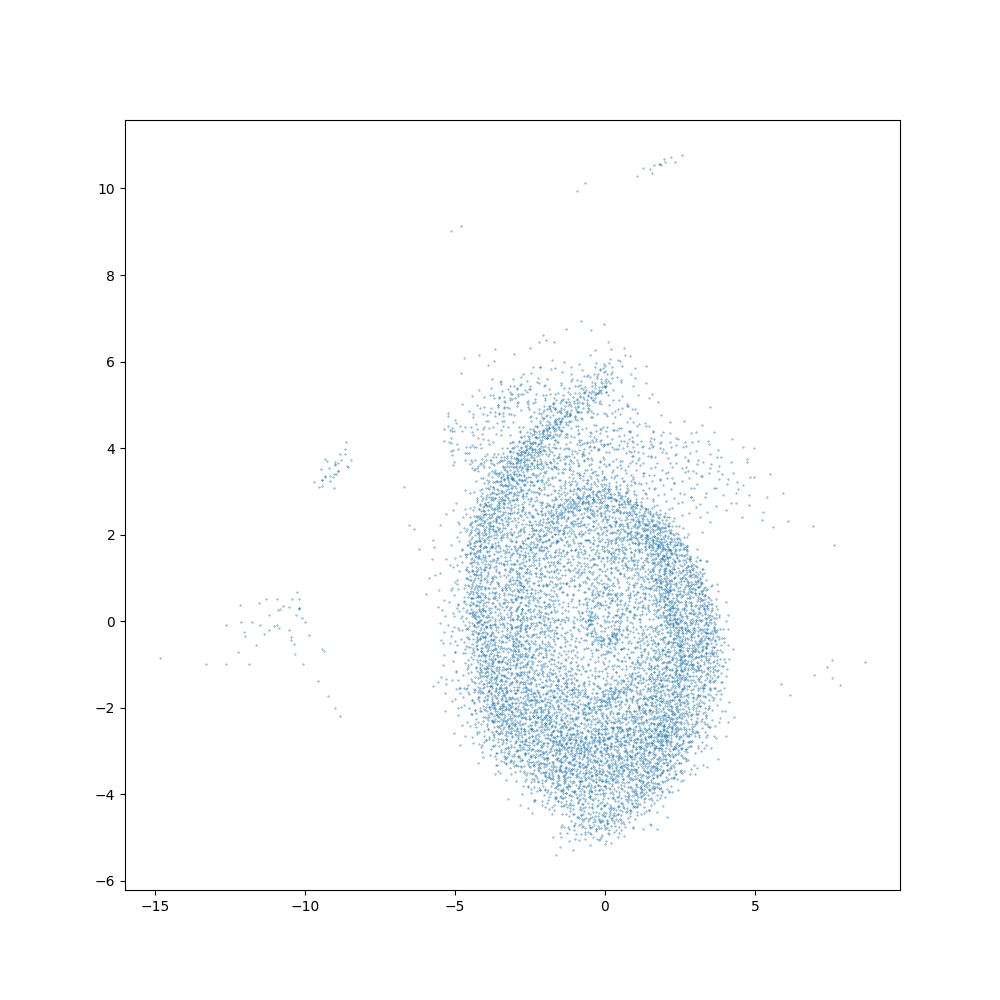

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Xs_i,Ys_i,s=0.1,alpha=1)

In [19]:
Rs_mean  = []
rho_sph_mean = []
deltaR  = 0.1
step    = 0
while(step + deltaR < 20):
    a = np.mean(rho_sph_z[(Rs_z > step ) & (Rs_z < step + deltaR) ] )
    minBin = np.min(Rs_z[ (Rs_z > step ) & (Rs_z < step + deltaR) ] )    
    maxBin = np.max(Rs_z[ (Rs_z > step ) & (Rs_z < step + deltaR) ] ) 

    b = np.round( (maxBin + minBin)*0.5, 2)
    rho_sph_mean.append(a)
    Rs_mean.append(b)
    step = step + 0.1

    
Rs_mean = [x for x in Rs_mean if str(x) != 'nan']
rho_sph_mean = [x for x in rho_sph_mean if str(x) != 'nan']

In [20]:
x = np.array(Rs_mean)
y = np.array(rho_sph_mean)

ylog = np.array( np.log10(y) )

f = interpolate.interp1d(x, y, kind='cubic')

xnew = np.linspace( np.min(Rs_mean), np.max(Rs_mean), 2000)
xnew = np.array(xnew)
ynew = f(xnew)

Initial_df_lim = df_filtered.loc[(Initial_df_sorted.Rs > np.min(Rs_mean)) & (Initial_df_sorted.Rs < np.max(Rs_mean)) ]
Initial_df_lim['rho_sph_log']  = np.log10(Initial_df_lim.rho)

Rs_i_lim   = Initial_df_lim['Rs']
rho_sph_i_lim = Initial_df_lim['rho']
Initial_df_lim['deltaRho'] = rho_sph_i_lim/f(Rs_i_lim) - 1.0

In [21]:
Filtered_df_lim   = Initial_df_lim.loc[(Initial_df_lim.deltaRho > 0.0) & (Initial_df_lim.deltaRho < 20.0)]
Filtered_df_lim['rho_sph_log']  = np.log10(Filtered_df_lim.rho)

Background_df_lim = Initial_df_lim.loc[Initial_df_lim.deltaRho < 0.0] 
Background_df_lim['rho_sph_log']  = np.log10(Background_df_lim.rho)

In [22]:
Filtered_df_lim####################################### Initial (limited to max(Rs_mean) )
Xs_i_lim  = Initial_df_lim['x']
Ys_i_lim  = Initial_df_lim['y']
Rs_i_lim  = Initial_df_lim['Rs']

rho_sph_i_lim     = Initial_df_lim['rho']
rho_sph_i_lim_log = Initial_df_lim['rho_sph_log'] 

####################################### Background (from rho-filtered)
Xs_b_lim  = Background_df_lim['x']
Ys_b_lim  = Background_df_lim['y']
Rs_b_lim  = Background_df_lim['Rs']

rho_sph_b_lim   = Background_df_lim['rho']
rho_sph_b_lim_log = Background_df_lim['rho_sph_log']  

####################################### Filtered (rho-filtered)
Xs_f_lim  = Filtered_df_lim['x']
Ys_f_lim  = Filtered_df_lim['y']
Rs_f_lim  = Filtered_df_lim['Rs']

rho_sph_f_lim     = Filtered_df_lim['rho']
rho_sph_f_lim_log = Filtered_df_lim['rho_sph_log'] 

In [23]:
cuts = [2,3,7.00,np.max(x)]

def line(x, a, b):
    return a*x + b

params1, params_covariance1 = optimize.curve_fit(line,x[x<=cuts[0]],ylog[x<=cuts[0]])
a1 = params1[0]
b1 = params1[1] 

params2, params_covariance2 = optimize.curve_fit(line,x[(x>cuts[0]) & (x<=cuts[1])],
                                                 ylog[(x>cuts[0]) & (x<=cuts[1])])
a2 = params2[0]
b2 = params2[1] 

params3, params_covariance3 = optimize.curve_fit(line,x[(x>cuts[1]) & (x<=cuts[2])],
                                                 ylog[(x>cuts[1]) & (x<=cuts[2])])
a3 = params3[0]
b3 = params3[1] 

params4, params_covariance4 = optimize.curve_fit(line,x[(x>cuts[2]) & (x<=cuts[3])],
                                                 ylog[(x>cuts[2]) & (x<=cuts[3])])
a4 = params4[0]
b4 = params4[1]

In [24]:
cuts

[2, 3, 7.0, 11.08]

In [25]:
Filtered_df_lim['rho_resta1']  = rho_sph_f_lim_log - line(Rs_f_lim,a1,b1) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta2']  = rho_sph_f_lim_log - line(Rs_f_lim,a2,b2) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta3']  = rho_sph_f_lim_log - line(Rs_f_lim,a3,b3) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta4']  = rho_sph_f_lim_log - line(Rs_f_lim,a4,b4) + np.min(rho_sph_f_lim_log) 

In [26]:
Filtered_df_lim.reset_index(drop=True, inplace=True)
Filtered_df_lim['rho_resta_final'] = pd.Series(dtype="float64") #Creating a column the will be filled in the next step

df = Filtered_df_lim #An alias for the filtered dataframe to simplify the code

#Getting the labels
rho_resta_final_label = df.columns.get_loc("rho_resta_final")
rho_resta1_label      = df.columns.get_loc("rho_resta1")
rho_resta2_label      = df.columns.get_loc("rho_resta2")
rho_resta3_label      = df.columns.get_loc("rho_resta3")
rho_resta4_label      = df.columns.get_loc("rho_resta4")

Rs_label             = df.columns.get_loc("Rs")
min_rho              = np.min(rho_sph_f_lim_log)

In [27]:
for i in range(len(Filtered_df_lim)): 
    
    if(df.iloc[i,Rs_label] < cuts[0]): 
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta1_label] 
            
    elif( (df.iloc[i,Rs_label] >= cuts[0]) & (df.iloc[i,Rs_label] < cuts[1])):  
            
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta2_label]
        
    elif( (df.iloc[i,Rs_label] >= cuts[1]) & (df.iloc[i,Rs_label] <= cuts[2])  ):
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta3_label]
        
    elif( (df.iloc[i,Rs_label] >= cuts[2]) & (df.iloc[i,Rs_label] <= cuts[3])  ):
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta4_label]

In [28]:
Filtered_df_lim['rho_resta_final_exp'] = 10**(Filtered_df_lim['rho_resta_final'])

Rs              = Filtered_df_lim.Rs
Xs              = Filtered_df_lim.x
Ys              = Filtered_df_lim.y
rho_initial     = Filtered_df_lim.rho
rho_initial_log = Filtered_df_lim.rho_sph_log
rho_final       = Filtered_df_lim.rho_resta_final_exp
rho_final_log   = Filtered_df_lim.rho_resta_final

In [29]:
Filtered_df_lim

,x,y,z,vx,vy,vz,lxvel,lyvel,lzvel,Potential,...,Rs,Zs,rho_sph_log,deltaRho,rho_resta1,rho_resta2,rho_resta3,rho_resta4,rho_resta_final,rho_resta_final_exp
0,-0.599143,0.297567,-0.118721,9.707195,-65.387703,28.574100,43.692421,-47.413933,-7.666734,-152664.984375,...,0.668968,-0.118721,-2.692718,0.382409,-4.331981,-4.360284,-5.222446,-1.025309,-4.331981,0.000047
1,0.202859,0.618619,-0.364854,-31.469739,12.826473,11.949539,18.566792,34.443005,19.856306,-149980.781250,...,0.651031,-0.364854,-2.715118,0.346843,-4.354027,-4.382554,-5.250573,-1.043481,-4.354027,0.000044
2,-0.440491,0.494145,-0.320909,-52.946099,36.440286,-9.003481,-0.409504,58.624195,42.506813,-150612.171875,...,0.661975,-0.320909,-2.780677,0.138421,-4.419803,-4.448192,-5.312638,-1.111620,-4.419803,0.000038
3,-0.318953,0.637972,-0.137935,-56.006669,-73.161590,32.071153,70.344643,-34.225807,51.550724,-151447.562500,...,0.713259,-0.137935,-2.642256,0.529518,-4.282395,-4.310143,-5.157842,-0.985290,-4.282395,0.000052
4,-0.236593,-0.672044,-0.194209,89.624155,-13.141759,18.741147,-6.571524,-24.711884,-86.223709,-150595.687500,...,0.712474,-0.194209,-2.700929,0.335959,-4.341053,-4.368810,-5.216766,-1.043778,-4.341053,0.000046
5,-0.230165,0.648450,-0.131177,-73.472341,-77.570443,31.996575,77.229935,-33.108330,68.159073,-151973.093750,...,0.688086,-0.131177,-2.570248,0.807726,-4.209889,-4.237952,-5.093872,-0.907347,-4.209889,0.000062
6,-0.634405,0.394296,-0.112737,-9.055690,-95.536771,26.598889,57.013771,-70.281647,16.092957,-150548.859375,...,0.746954,-0.112737,-2.780415,0.135527,-4.421221,-4.448548,-5.285244,-1.131394,-4.421221,0.000038
7,-0.076458,0.679917,0.183808,-111.858802,-24.171025,5.559855,49.842102,22.787170,102.063614,-152137.062500,...,0.684202,0.183808,-2.578725,0.775984,-4.218290,-4.246402,-5.103589,-0.914909,-4.218290,0.000060
8,-0.423788,-0.534843,0.065375,104.348800,-67.539354,-5.128703,-16.423807,-84.687088,-79.041046,-153194.406250,...,0.682388,0.065375,-2.646276,0.521689,-4.285805,-4.313939,-5.171719,-0.982032,-4.285805,0.000052
9,-0.181206,0.705003,0.295431,-83.832251,-36.225326,-3.277016,36.492622,1.342789,82.807083,-149397.906250,...,0.727918,0.295431,-2.586868,0.748446,-4.227297,-4.254862,-5.097774,-0.933359,-4.227297,0.000059


In [30]:
Filtered_df_lim[['x','y','z','Rs','vx','vy','vz','rho_resta_final_exp']].to_csv(f'DATA/processed/TracingPoints/data_rho_{id}_.csv',index=False)

Filtered_df_lim[['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential',
       'U', 'rho', 'Rs', 'Zs', 'rho_sph_log', 'deltaRho', 'rho_resta1', 'rho_resta_final',
       'rho_resta_final_exp']].to_csv(f'DATA/processed/TracingPoints/data_rho_{id}_filtered.csv',index=False)

(-5.258889231863321, 8.248327183322125, -5.95051246723898, 11.531791296305745)

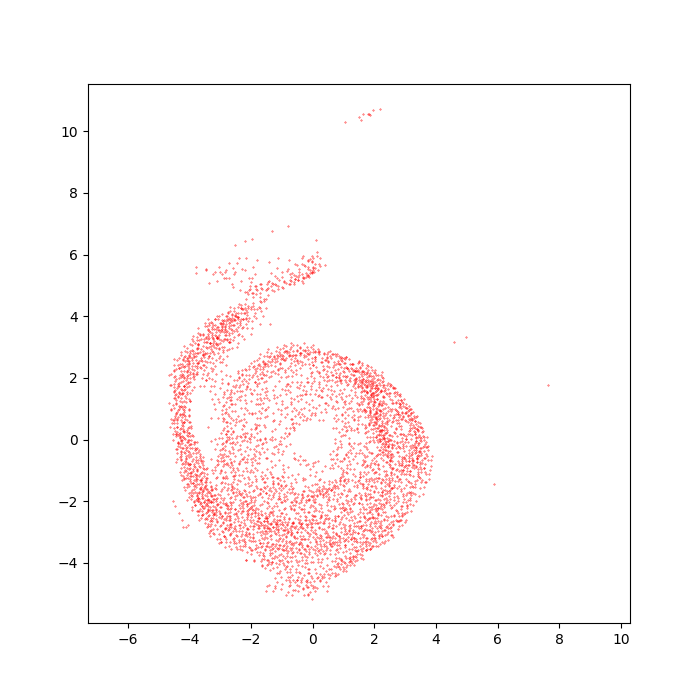

In [37]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(Xs,Ys,s=0.1,alpha=1, c ='red')
plt.axis('equal')


In [93]:
%matplotlib widget

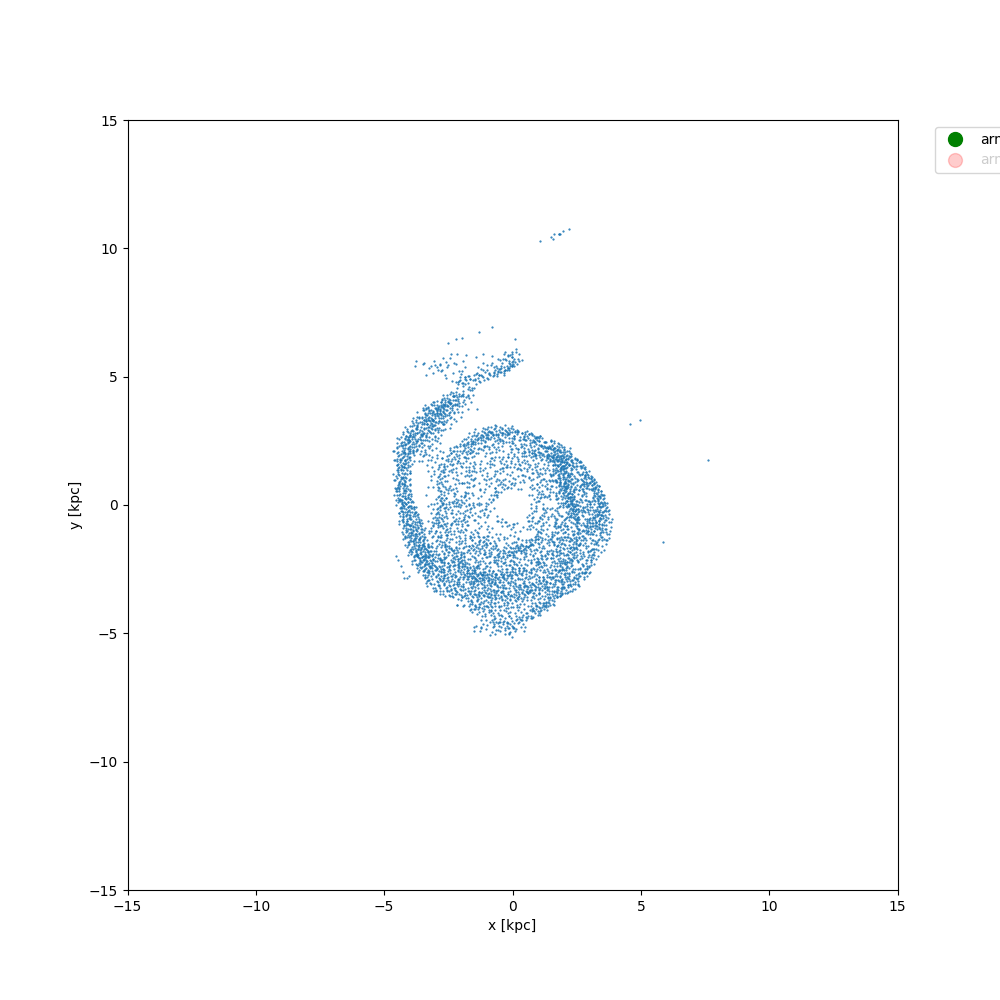

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Xs,Ys,s=0.3,alpha=1)
R = 15
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

#ax.scatter(x_trace_arm1_rho,y_trace_arm1_rho,color='red',s=200,marker='*')

#for i in range(len(nums1_rho)):
#    ax.annotate(nums1_rho[i], (x_trace_arm1_rho[i], y_trace_arm1_rho[i]),fontsize=15)
klicker = clicker(ax, ["arm1",'arm2'], markers=["o","o"], colors = ['green','red'], markersize = 10)
ax.set_xlabel(r'x [kpc]')
ax.set_ylabel(r'y [kpc]')
ax.set_aspect('equal')

In [95]:
dict_pos = klicker.get_positions()
arm1 = pd.DataFrame({'x':dict_pos['arm1'][:,0],'y':dict_pos['arm1'][:,1]})
arm2 = pd.DataFrame({'x':dict_pos['arm2'][:,0],'y':dict_pos['arm2'][:,1]})

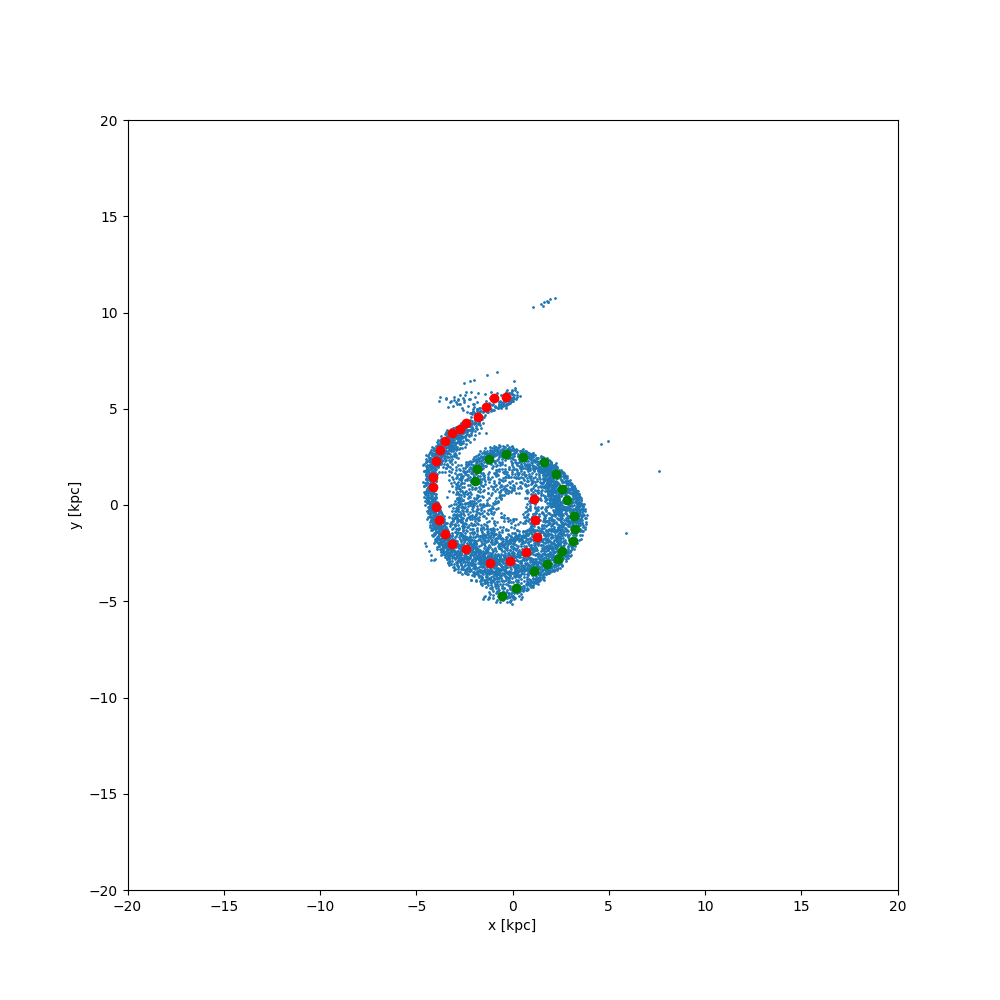

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Xs,Ys,s=1,alpha=1)
ax.scatter(arm1.x, arm1.y, color = 'green')
ax.scatter(arm2.x, arm2.y, color = 'red')

R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_xlabel(r'x [kpc]')
ax.set_ylabel(r'y [kpc]')
ax.set_aspect('equal')

In [97]:
arm1.to_csv(f'DATA/processed/TracingPoints/arm_tracing_{id}_arm1_rho_dani.csv', index = False)
arm2.to_csv(f'DATA/processed/TracingPoints/arm_tracing_{id}_arm2_rho_dani.csv', index = False)